In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.impute import SimpleImputer
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.callbacks import EarlyStopping


In [2]:
# Load the CSV file for proton flux
# Replace 'proton_flux_data.csv' with your actual file path
df_proton = pd.read_csv('C:\\Users\\shahi\\OneDrive\\Desktop\\Fatema_NASA\\Van_Allen\\proton_flux_3_days.csv')

# Print the first few rows to understand its structure
print(df_proton.head())
print(df_proton.columns)


               time_tag  satellite      flux     energy
0  2024-08-25T12:10:00Z         18  0.341341    >=1 MeV
1  2024-08-25T12:10:00Z         18  0.193341   >=10 MeV
2  2024-08-25T12:10:00Z         18  0.184341  >=100 MeV
3  2024-08-25T12:10:00Z         18  0.186341   >=30 MeV
4  2024-08-25T12:10:00Z         18  0.196341    >=5 MeV
Index(['time_tag', 'satellite', 'flux', 'energy'], dtype='object')


In [3]:
# Convert the 'time_tag' column to datetime and set it as index
df_proton['time_tag'] = pd.to_datetime(df_proton['time_tag'])
df_proton.set_index('time_tag', inplace=True)

# Handle missing values in the 'flux' column
imputer = SimpleImputer(strategy='mean')
df_proton['flux'] = imputer.fit_transform(df_proton[['flux']])

# Normalize the 'flux' column
scaler = MinMaxScaler()
df_proton['flux_scaled'] = scaler.fit_transform(df_proton[['flux']])


In [4]:
def create_sequences(data, seq_length):
    xs, ys = [], []
    for i in range(len(data) - seq_length):
        x = data[i:i + seq_length]
        y = data[i + seq_length]
        xs.append(x)
        ys.append(y)
    return np.array(xs), np.array(ys)

# Define sequence length (adjust based on your data frequency)
seq_length = 24  

# Create sequences
X_proton, y_proton = create_sequences(df_proton['flux_scaled'].values, seq_length)

# Split data into training and testing sets
split_proton = int(0.8 * len(X_proton))
X_train_proton, X_test_proton = X_proton[:split_proton], X_proton[split_proton:]
y_train_proton, y_test_proton = y_proton[:split_proton], y_proton[split_proton:]

# Reshape data for LSTM
X_train_proton = X_train_proton.reshape((X_train_proton.shape[0], X_train_proton.shape[1], 1))
X_test_proton = X_test_proton.reshape((X_test_proton.shape[0], X_test_proton.shape[1], 1))


In [5]:
model_proton = Sequential()
model_proton.add(LSTM(50, activation='relu', input_shape=(X_train_proton.shape[1], 1)))
model_proton.add(Dense(1))
model_proton.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
history_proton = model_proton.fit(X_train_proton, y_train_proton, epochs=50, batch_size=32, validation_data=(X_test_proton, y_test_proton), callbacks=[EarlyStopping(monitor='val_loss', patience=5)])


C:\Users\shahi\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
172/172 ━━━━━━━━━━━━━━━━━━━━ 28s 72ms/step - loss: 2.3383e-06 - val_loss: 0.0023
Epoch 2/50
172/172 ━━━━━━━━━━━━━━━━━━━━ 12s 71ms/step - loss: 1.9020e-06 - val_loss: 0.0023
Epoch 3/50
172/172 ━━━━━━━━━━━━━━━━━━━━ 11s 65ms/step - loss: 2.0199e-06 - val_loss: 0.0023
Epoch 4/50
172/172 ━━━━━━━━━━━━━━━━━━━━ 9s 51ms/step - loss: 1.7454e-06 - val_loss: 0.0023
Epoch 5/50
172/172 ━━━━━━━━━━━━━━━━━━━━ 20s 102ms/step - loss: 1.6586e-06 - val_loss: 0.0023
Epoch 6/50
172/172 ━━━━━━━━━━━━━━━━━━━━ 12s 53ms/step - loss: 1.7588e-06 - val_loss: 0.0023
Epoch 7/50
172/172 ━━━━━━━━━━━━━━━━━━━━ 10s 57ms/step - loss: 1.4814e-06 - val_loss: 0.0023
Epoch 8/50
172/172 ━━━━━━━━━━━━━━━━━━━━ 10s 53ms/step - loss: 1.8383e-06 - val_loss: 0.0023
Epoch 9/50
172/172 ━━━━━━━━━━━━━━━━━━━━ 13s 66ms/step - loss: 1.4742e-06 - val_loss: 0.0023
Epoch 10/50
172/172 ━━━━━━━━━━━━━━━━━━━━ 22s 73ms/step - loss: 1.3715e-06 - val_loss: 0.0023
Epoch 11/50
172/172 ━━━━━━━━━━━━━━━━━━━━ 18s 56ms/step - loss: 1.5784e-06 - val

In [6]:
# Predict on the test data
y_pred_proton = model_proton.predict(X_test_proton)

# Rescale the predictions and actual values back to original scale
y_test_proton_rescaled = scaler.inverse_transform(y_test_proton.reshape(-1, 1))
y_pred_proton_rescaled = scaler.inverse_transform(y_pred_proton)


43/43 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step


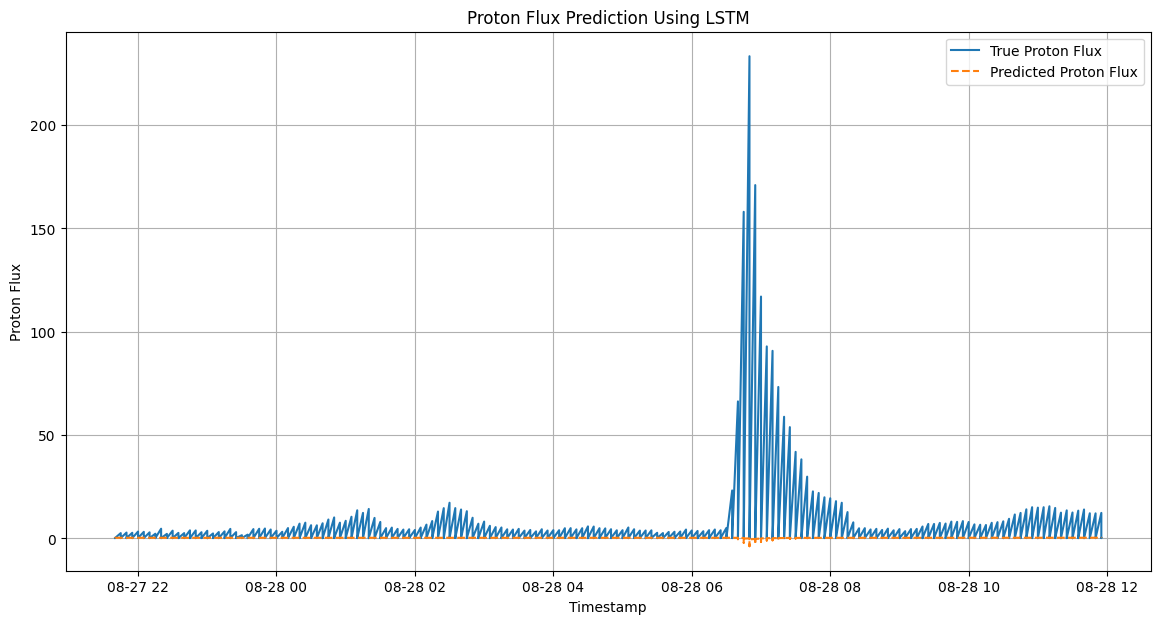

In [7]:
# Plot the results
plt.figure(figsize=(14, 7))
plt.plot(df_proton.index[-len(y_test_proton):], y_test_proton_rescaled, label='True Proton Flux')
plt.plot(df_proton.index[-len(y_test_proton):], y_pred_proton_rescaled, label='Predicted Proton Flux', linestyle='--')
plt.title('Proton Flux Prediction Using LSTM')
plt.xlabel('Timestamp')
plt.ylabel('Proton Flux')
plt.legend()
plt.grid(True)
plt.show()
